In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud

In [5]:
# Stile für Visualisierungen 
plt.style.use('seaborn-v0_8-whitegrid')  # Matplotlib-Stil mit weißem Hintergrund und Gitternetz
plt.rcParams['figure.figsize'] = (12, 8)  # Standardgröße der Plots: 12x8 Zoll
plt.rcParams['font.size'] = 12           # Standard-Schriftgröße: 12pt
sns.set_style("whitegrid")               # Seaborn-Stil: weißer Hintergrund mit Gitternetz

In [6]:
# Laden der vorverarbeiteten Daten aus den vorherigen Notebooks
try:
    # TF-IDF Matrix
    tfidf_matrix = np.load('../models/tfidf_matrix.npy')
    tfidf_vectorizer = joblib.load('../models/tfidf_vectorizer.joblib')
    
    # Count Matrix für LDA
    count_matrix = np.load('../models/count_matrix_for_lda.npy')
    count_vectorizer = joblib.load('../models/count_vectorizer_for_lda.joblib')
    
    # Word2Vec Dokumentvektoren
    doc_vectors_w2v = np.load('../models/doc_vectors_w2v.npy')
    
    print("Alle Vektordaten erfolgreich geladen!")
except FileNotFoundError as e:
    print(f"Fehler beim Laden der vorverarbeiteten Daten: {e}")
    print("Erst 1. Datenvorverarbeitung vollständig ausführen und danach 2. Vektorisierung ausführen, damit alle Datensätze vorhanden sind.")

Alle Vektordaten erfolgreich geladen!


In [7]:
##########################################################
# 1. LSA mit TF-IDF
##########################################################

# Anzahl der Themen für LSA auswählen
n_components_lsa = 10 # Variable kann geändert werden um verschiedene Ausgaben zu testen, 10 erstmal für eine bessere Übersicht gewählt.

# LSA-Modell erstellen und trainieren
print('LSA-Modell wird trainiert...')
lsa_model = TruncatedSVD(n_components=n_components_lsa, random_state=42)
lsa_components = lsa_model.fit_transform(tfidf_matrix)
print('LSA-Modell fertig trainiert')

LSA-Modell wird trainiert...
LSA-Modell fertig trainiert


In [8]:
# Erklärte Varianz der Komponenten
explained_variance = lsa_model.explained_variance_ratio_.sum()
print(f"Erklärte Varianz durch {n_components_lsa} Komponenten: {explained_variance:.2%}") 

Erklärte Varianz durch 10 Komponenten: 9.00%


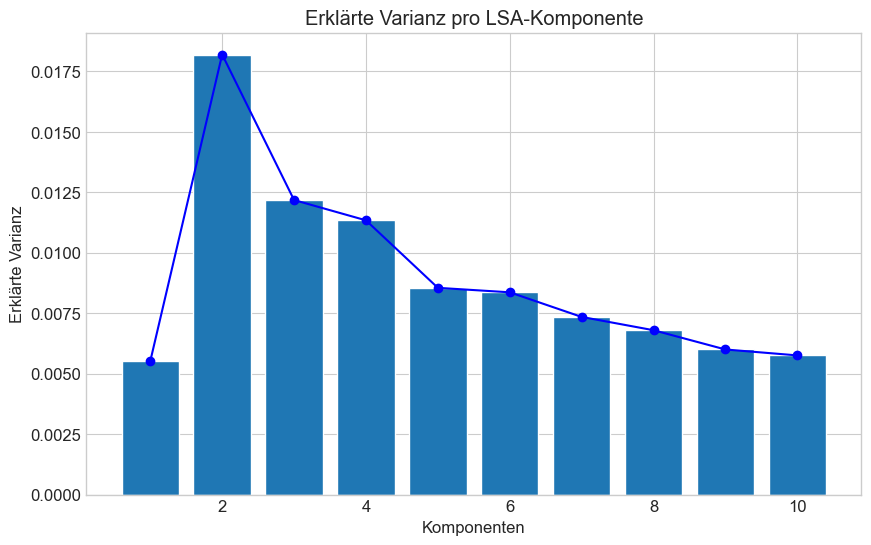

In [9]:
# Visualisierung der erklärten Varianz
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components_lsa + 1), lsa_model.explained_variance_ratio_, 'b-', marker='o')
plt.bar(range(1, n_components_lsa + 1), lsa_model.explained_variance_ratio_)
plt.xlabel('Komponenten')
plt.ylabel('Erklärte Varianz')
plt.title('Erklärte Varianz pro LSA-Komponente')
plt.savefig('../results/lsa_explained_variance.png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
# Top Begriffe je LSA-Komponente identifizieren
feature_names = tfidf_vectorizer.get_feature_names_out()
lsa_components_df = pd.DataFrame()

# Speichern der wichtigsten Begriffe für jede Komponente
n_top_words = 15
lsa_top_words = {}

for i, component in enumerate(lsa_model.components_): # Iterate über jedes LSA-Thema
    # Indizes der Wörter mit den höchsten Werten
    top_indices = component.argsort()[:-n_top_words-1:-1] 
    top_words = [feature_names[idx] for idx in top_indices]
    top_weights = [component[idx] for idx in top_indices]
    
    # Als Dataframe speichern
    component_df = pd.DataFrame({
        'Word': top_words,
        'Weight': top_weights
    })
    lsa_components_df = pd.concat([lsa_components_df, component_df], axis=1)
    
    # Für JSON speichern
    lsa_top_words[f"topic_{i+1}"] = [
        {"word": word, "weight": float(weight)} 
        for word, weight in zip(top_words, top_weights)
    ]
    
    print(f"LSA Thema {i+1}: {', '.join(top_words[:10])}")

# LSA-Themen als JSON speichern
with open('../results/lsa_topics.json', 'w') as f:
    json.dump(lsa_top_words, f, indent=4)


LSA Thema 1: credit, account, payment, loan, report, debt, bank, would, card, call
LSA Thema 2: credit, report, credit report, debt, reporting, collection, account, agency, experian, equifax
LSA Thema 3: debt, call, collection, phone, number, company, calling, loan, collection agency, agency
LSA Thema 4: loan, mortgage, report, credit report, payment, credit, modification, home, reporting, owen
LSA Thema 5: account, debt, bank, collection, payment, agency, fee, check, collection agency, bank america
LSA Thema 6: payment, debt, late, paid, card, collection, balance, fee, bill, interest
LSA Thema 7: debt, card, credit card, fargo, well fargo, bank, well, loan, america, bank america
LSA Thema 8: fargo, well fargo, well, payment, late, fargo bank, call, bill, late fee, account
LSA Thema 9: loan, account, student, student loan, interest, collection, rate, paid, private, school
LSA Thema 10: bank, america, bank america, credit report, report, debt, check, credit, payment, fee


In [12]:
##########################################################
# 1. Latent Drichilet Allocation (LDA) mit Bag Of Words
##########################################################

# Funktion zur Berechnung von Kohärenzwerten (hier als Log-Likelihood) und Perplexity für verschiedene Topic-Anzahlen
def compute_coherence_values(count_matrix, count_vect, start=2, limit=20, step=2):
    coherence_values = []    # Liste zur Speicherung der Kohärenzwerte (Log-Likelihoods) für jedes Modell
    model_list = []          # Liste zur Speicherung der trainierten LDA-Modelle
    perplexity_values = []   # Liste zur Speicherung der Perplexity-Werte (ein Maß für Modellqualität)

    # Schleife über die gewünschte Anzahl an Themen (z. B. 2, 4, 6, ..., 20)
    for num_topics in range(start, limit+1, step):
        print(f"LDA Modell mit {num_topics} Themen trainieren...")

        # https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
        # Initialisierung eines LDA-Modells mit aktueller Themenanzahl
        lda = LatentDirichletAllocation(
            n_components=num_topics,       # Anzahl der zu entdeckenden Themen (Topics)
            max_iter=5,                    # Anzahl der Trainingsdurchläufe (Iterationen)
            learning_method='online',      # Lernmethode: 'online' für inkrementelles Training (schneller bei großen Datensätzen)
            random_state=42,               # Zufallsstart fixieren für Reproduzierbarkeit
            batch_size=128,                # Anzahl der Dokumente pro Mini-Batch beim Training
            n_jobs=-1,                     # Alle verfügbaren CPU-Kerne nutzen
            verbose=0,                     # Keine Ausgaben während des Trainings (0 = keine Ausgabe, 1 = Fortschritt anzeigen)
        )

        # LDA-Modell auf der Dokument-Term-Matrix trainieren
        lda.fit(count_matrix)

        # Perplexity berechnen (niedriger ist besser; misst, wie gut das Modell neue Daten erklärt)
        perplexity_values.append(lda.perplexity(count_matrix))

        # Das trainierte Modell zur späteren Analyse speichern
        model_list.append(lda)

        # Log-Likelihood berechnen (höher ist besser; Maß für die Modellgüte während des Trainings)
        coherence_values.append(lda.score(count_matrix))

    # Rückgabe: Liste der Modelle, Liste der Kohärenzwerte, Liste der Perplexity-Werte
    return model_list, coherence_values, perplexity_values


In [ ]:
# Nach der ersten Darstellung der LDA-Modelle mit 20 Themen, wurde die Anzahl der Themen auf 10 reduziert, weil nach 10 Themen nicht mehr stark fällt. 
# Dadurch war das Training nach 6 Minuten fertig.
# Diese Funktion nimmt einige Zeit in Anspruch, deshalb wurde auch n_jobs auf alle CPUs gestellt. 
# Die ersten Test: Mit 5 Durchläufen ca. 20 Minuten.  Bei 10 waren es mehr als 1h. Durch max_iter auf 5, bei 10 Durchgängen ca. 28 Minuten.
# Definiert den Bereich für die Anzahl der LDA-Themen:
# start = kleinste Themenanzahl, limit = größte Themenanzahl, step = Schrittweite zwischen den Tests -> für range()
# Beispiel: range(2, 21, 2) → [2, 4, 6, ..., 20]
start, limit, step = 2, 10, 2
model_list, coherence_values, perplexity_values = compute_coherence_values(
    count_matrix, count_vectorizer, start=start, limit=limit, step=step
)

print("Training der LDA-Modelle abgeschlossen.")

LDA Modell mit 2 Themen trainieren...
LDA Modell mit 4 Themen trainieren...
LDA Modell mit 6 Themen trainieren...
LDA Modell mit 8 Themen trainieren...
LDA Modell mit 10 Themen trainieren...
Training der LDA-Modelle abgeschlossen.


In [14]:
# Finde den Index des besten Wertes (höchste Kohärenz / Log Likelihood) in der Liste
optimal_model_idx = coherence_values.index(max(coherence_values))

# Rechne aus, wie viele Themen das Modell mit dem besten Wert hatte
optimal_num_topics = start + optimal_model_idx * step

# (Startwert + Index * Schrittweite)
print(f"Optimale Anzahl Themen basierend auf Log Likelihood: {optimal_num_topics}")

Optimale Anzahl Themen basierend auf Log Likelihood: 10


In [17]:
# Kohärenzwerte visualisieren
x = range(start, limit+1, step)
plt.figure(figsize=(12, 6))

# Plot für Perplexity/Verwirrung/Verworrenheit (niedriger ist besser)
plt.subplot(1, 2, 1)
plt.plot(x, perplexity_values, marker='o')
plt.xlabel("Anzahl Themen")
plt.ylabel("Perplexity")
plt.title("Perplexity vs. Themenanzahl")

plt.tight_layout()
plt.savefig('../results/lda_coherence_values.png', dpi=300, bbox_inches='tight')
plt.close()

# Bestes LDA-Modell verwenden
best_lda_model = model_list[optimal_model_idx]

# LDA-Themen Visualisierung
feature_names = count_vectorizer.get_feature_names_out()
lda_top_words = {}